# ACGANに入れる前にDiscriminatorをpretrainしてみる

## 必要なmodule

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import random

## データの前処理

In [2]:
class Transform(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        sample = np.array(sample, dtype = np.float32)
        sample = torch.tensor(sample)
        return (sample/127.5)-1
    
transform = Transform()

## Datasetの定義

In [3]:
from tqdm import tqdm

class dataset_full(torch.utils.data.Dataset):
    
    def __init__(self, img, label, transform=None):
        self.transform = transform
        self.data_num = len(img)
        self.data = []
        self.label = []
        for i in tqdm(range(self.data_num)):
            self.data.append([img[i]])
            self.label.append(label[i]) #同じ実装で動くようにラベルを0～9に振り直す
        self.data_num = len(self.data)
            
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = np.identity(49)[self.label[idx]]
        out_label = np.array(out_label, dtype = np.float32)
        
        if self.transform:
            out_data = self.transform(out_data)
            
        return out_data, out_label

## バイナリファイルからDLしてDatasetにする

In [4]:
path = %pwd
train_img = np.load('{}/k49-train-imgs.npz'.format(path))
train_img = train_img['arr_0']
train_label = np.load('{}/k49-train-labels.npz'.format(path))
train_label = train_label['arr_0']

test_img = np.load('{}/k49-test-imgs.npz'.format(path))
test_img = test_img['arr_0']
test_label = np.load('{}/k49-test-labels.npz'.format(path))
test_label = test_label['arr_0']

train_data = dataset_full(train_img, train_label, transform=transform)
print(len(train_data))
test_data = dataset_full(test_img, test_label, transform=transform)
print(len(test_data))

100%|██████████| 38547/38547 [00:00<00:00, 1628995.83it/s]

232365
38547


## Dataloaderを作成

In [5]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 6)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 6)

## Discriminatorの定義

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_class):
        super(Discriminator, self).__init__()
        self.num_class = num_class
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), #入力は1チャネル(白黒だから), フィルターの数64, フィルターのサイズ4*4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        
        self.fc_TF = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        self.fc_class = nn.Sequential(
            nn.Linear(1024, num_class),
            nn.LogSoftmax(dim=1),
        )
        
        self.init_weights()
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm1d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
        
    def forward(self, img):
        x = self.conv(img)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        x_TF = self.fc_TF(x)
        x_class = self.fc_class(x)
        return x_TF, x_class

## 1エポックごとに計算する関数を定義

In [7]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_func(D_model, batch_size, criterion, train_loader, optimizer, scheduler):
    D_model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        if imgs.size()[0] != batch_size:
            break
            
        img, label = imgs.to(device), labels.to(device)
        
        #勾配の初期化
        optimizer.zero_grad()
        
        #順伝播
        TF_output, class_output = D_model(img)
        
        #loss計算
        CEE_label = torch.max(label, 1)[1].to(device)
        class_loss = criterion(class_output, CEE_label)
        
        #逆伝播
        class_loss.backward()
        
        #optimizer更新
        optimizer.step()
        
        #train_lossとaccを蓄積
        train_loss += class_loss.item()
        train_acc += (class_output.argmax(dim=1) == label.argmax(dim=1)).sum().item()
        
    if scheduler != 'None':
        scheduler.step()
        
    return train_loss/len(train_loader), train_acc/(batch_size * len(train_loader))

def val_func(D_model, batch_size, criterion, val_loader):
    D_model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            img, label = imgs.to(device), labels.to(device)
            
            #順伝播
            TF_output, class_output = D_model(img)
            
            #loss計算
            CEE_label = torch.max(label, 1)[1].to(device)
            class_loss = criterion(class_output, CEE_label)
            
            #val_lossとaccを蓄積
            val_loss += class_loss.item()
            val_acc += (class_output.argmax(1) == label.argmax(1)).sum().item()
            
    return val_loss/len(val_loader), val_acc/(batch_size * len(val_loader))

## モデルをエポックごとに計算し、結果を表示

In [8]:
#再現性確保のためseed値固定
SEED = 1111
random.seed(SEED)
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

def model_run(num_epochs, batch_size = batch_size, train_loader = train_loader, val_loader = test_loader, device = device):
    #クラス数
    num_class = 49
    
    #モデル定義
    D_model = Discriminator(num_class).to(device)
    
    #loss定義
    class_criterion = nn.NLLLoss().to(device)
    
    #optimizerの定義
    D_optimizer = torch.optim.Adam(D_model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)

    #shedulerの定義
    scheduler = 'None'
    
    train_loss_list = []
    val_loss_list = []
    
    train_acc_list = []
    val_acc_list = []
    
    all_time = time.time()
    for epoch in range(num_epochs):
        
        start_time = time.time()
        train_loss, train_acc = train_func(D_model, batch_size, class_criterion, train_loader, D_optimizer, scheduler)
        val_loss, val_acc = val_func(D_model, batch_size, class_criterion, val_loader)
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        
        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60
        
        #エポックごとに結果を表示
        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tLoss: {val_loss:.4f}(valid)\t|\tAcc: {val_acc * 100:.1f}%(valid)')

    torch.save({
                'epoch':num_epochs,
                'model_state_dict':D_model.state_dict(),
                'optimizer_state_dict':D_optimizer.state_dict(),
                'loss':train_loss,
            }, './pretrained_D_model_{}'.format(num_epochs))
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [9]:
train_loss_list, val_loss_list, train_acc_list, val_acc_list = model_run(20)

Epoch: 1  | 所要時間 0 分 6 秒
	Loss: 0.5531(train)	|	Acc: 86.5%(train)
	Loss: 0.5054(valid)	|	Acc: 86.5%(valid)
Epoch: 2  | 所要時間 0 分 6 秒
	Loss: 0.2018(train)	|	Acc: 94.7%(train)
	Loss: 0.3757(valid)	|	Acc: 89.8%(valid)
Epoch: 3  | 所要時間 0 分 6 秒
	Loss: 0.1381(train)	|	Acc: 96.3%(train)
	Loss: 0.3320(valid)	|	Acc: 91.1%(valid)
Epoch: 4  | 所要時間 0 分 6 秒
	Loss: 0.1019(train)	|	Acc: 97.2%(train)
	Loss: 0.3250(valid)	|	Acc: 91.3%(valid)
Epoch: 5  | 所要時間 0 分 6 秒
	Loss: 0.0782(train)	|	Acc: 97.8%(train)
	Loss: 0.3272(valid)	|	Acc: 91.3%(valid)
Epoch: 6  | 所要時間 0 分 6 秒
	Loss: 0.0601(train)	|	Acc: 98.3%(train)
	Loss: 0.3131(valid)	|	Acc: 91.8%(valid)
Epoch: 7  | 所要時間 0 分 6 秒
	Loss: 0.0480(train)	|	Acc: 98.6%(train)
	Loss: 0.3315(valid)	|	Acc: 91.5%(valid)
Epoch: 8  | 所要時間 0 分 6 秒
	Loss: 0.0389(train)	|	Acc: 98.8%(train)
	Loss: 0.3532(valid)	|	Acc: 91.1%(valid)
Epoch: 9  | 所要時間 0 分 6 秒
	Loss: 0.0325(train)	|	Acc: 99.0%(train)
	Loss: 0.3612(valid)	|	Acc: 91.1%(valid)
Epoch: 10  | 所要時間 0 分 6 秒
	Loss: 0.02

## loss表示

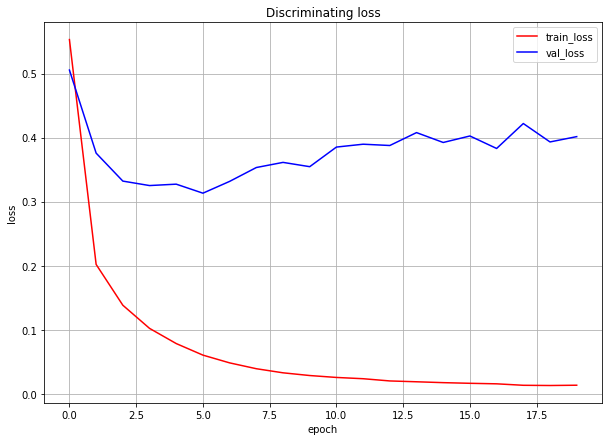

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(train_loss_list)),train_loss_list,label='train_loss',color='r', ls='-')
loss.plot(range(len(val_loss_list)),val_loss_list,label='val_loss',color='b',ls='-')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
loss.set_title('Discriminating loss')

loss.legend()
loss.grid()

fig.show()


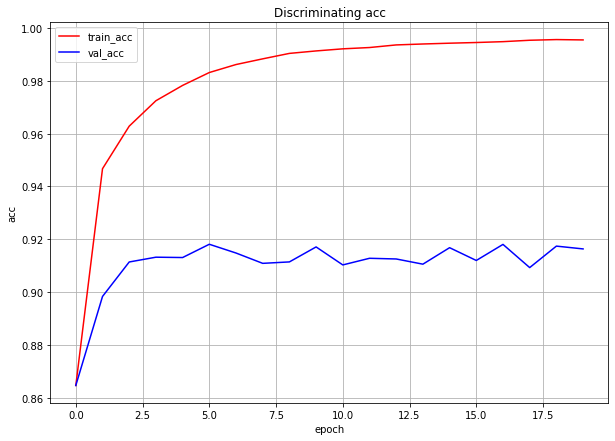

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

acc = fig.add_subplot(1,1,1)

acc.plot(range(len(train_acc_list)),train_acc_list,label='train_acc',color='r', ls='-')
acc.plot(range(len(val_acc_list)),val_acc_list,label='val_acc',color='b',ls='-')

acc.set_xlabel('epoch')
acc.set_ylabel('acc')
acc.set_title('Discriminating acc')

acc.legend()
acc.grid()

fig.show()